<a href="https://colab.research.google.com/github/michellecxy015/ml-finacne/blob/main/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a Deep NN

Feature Set and  Hyperparameter Evaluation

Imports & Settings

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import tensorflow as tf
from itertools import product

1. Load and precess the data

In [7]:
df = pd.read_excel("market_data.xlsx", sheet_name="US")
target_col = '_MKT'
date_col   = 'Date'

In [3]:
# Drop rows with missing values
df = df.dropna()

In [14]:
print(df.columns.tolist())

['Date', 'EMP', 'PE', 'CAPE', 'DY', 'Rho', 'MOV ', 'IR', 'RR', 'Y02', 'Y10', 'STP', 'CF', 'MG', 'RV', 'ED', 'UN', 'GDP', 'M2', 'CPI', 'DIL', 'YSS', 'NYF', '_AU', '_DXY', '_LCP', '_TY', '_OIL', '_MKT', '_VA', '_GR']


2. Define signal set

In [15]:
signal_sets = {
    "Set 1: Valuation"        : ['PE', 'CAPE', 'DY'],
    "Set 2: Interest Rates"   : ['IR', 'RR', 'Y02', 'Y10', 'STP'],
    "Set 3: Macro Conditions" : ['GDP', 'M2', 'CPI', 'UN', 'CF'],
    "Set 4: Corporate Health" : ['MG', 'RV', 'ED'],
    "Set 5: Risk Sentiment"   : ['Rho','MOV ', 'YSS', 'NYF', '_DXY', '_OIL'],
    "Set 6: Style & Asset"    : ['_VA', '_GR', '_AU', '_TY'],
    "Set 7: Full Set"         : [col for col in df.columns if col not in ['Date', '_MKT']]
}

3. Define MultipleTimeSeriesCV

In [8]:
class MultipleTimeSeriesCV:
    """
    train: [start, mid)
    text: [mid, end)
    test_size :total ratio
    """
    def __init__(self, n_splits=5, test_size=0.2):
        self.n_splits = n_splits
        self.test_size = test_size

    def split(self, X):
        n_samples = len(X)
        fold_size = int((n_samples * (1 - self.test_size)) / self.n_splits)
        for i in range(self.n_splits):
            start = i * fold_size
            mid   = start + fold_size
            end   = mid + int(n_samples * self.test_size)
            if end > n_samples:          # boundary check
                break
            yield list(range(start, mid)), list(range(mid, end))



4. Define hyperparameter grid

In [10]:
hidden_configs = [(64, 32), (128, 64), (32, 16)]  # (hidden1, hidden2)
dropout_rates  = [0.2, 0.3]
param_grid     = list(product(hidden_configs, dropout_rates))

5. Main loop: signal sets × hyperparameters

In [16]:
results = []
for sig_name, features in signal_sets.items():
    X_all = df[features].values
    y_all = df[target_col].values

    cv = MultipleTimeSeriesCV(n_splits=5, test_size=0.2)
    for (h1, h2), dr in param_grid:
        ic_folds, sharpe_folds = [], []

        for train_idx, test_idx in cv.split(X_all):
            X_train, X_test = X_all[train_idx], X_all[test_idx]
            y_train, y_test = y_all[train_idx], y_all[test_idx]

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test  = scaler.transform(X_test)

            # -------- Build and train model --------
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(h1, activation='relu'),
                tf.keras.layers.Dropout(dr),
                tf.keras.layers.Dense(h2, activation='relu'),
                tf.keras.layers.Dropout(dr),
                tf.keras.layers.Dense(1)  # Linear output
            ])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          loss='mse')
            model.fit(X_train, y_train,
                      epochs=50, batch_size=32, verbose=0,
                      validation_split=0.2,
                      callbacks=[tf.keras.callbacks.EarlyStopping(
                          patience=5, restore_best_weights=True)])

            # -------- Predict and evaluate --------
            y_pred = model.predict(X_test, verbose=0).flatten()
            ic     = spearmanr(y_pred, y_test).correlation
            sharpe = np.mean(y_pred) / np.std(y_pred)

            ic_folds.append(ic)
            sharpe_folds.append(sharpe)

        # --- Store cross-validated results ---
        results.append({
            "Signal Set"   : sig_name,
            "Hidden Layers": f"{h1}-{h2}",
            "Dropout"      : dr,
            "Avg IC"       : round(np.nanmean(ic_folds), 3),
            "Avg Sharpe"   : round(np.nanmean(sharpe_folds), 3)
        })


6. Export results

In [17]:
results_df = pd.DataFrame(results).sort_values(
    ["Avg IC", "Avg Sharpe"], ascending=False)

print(results_df)

                 Signal Set Hidden Layers  Dropout  Avg IC  Avg Sharpe
33     Set 6: Style & Asset        128-64      0.3   0.613       2.733
34     Set 6: Style & Asset         32-16      0.2   0.609       3.081
30     Set 6: Style & Asset         64-32      0.2   0.602       2.516
31     Set 6: Style & Asset         64-32      0.3   0.602       2.510
32     Set 6: Style & Asset        128-64      0.2   0.601       2.498
35     Set 6: Style & Asset         32-16      0.3   0.601       2.470
5          Set 1: Valuation         32-16      0.3   0.559       2.634
38          Set 7: Full Set        128-64      0.2   0.533       1.556
39          Set 7: Full Set        128-64      0.3   0.524       1.500
3          Set 1: Valuation        128-64      0.3   0.522       2.152
2          Set 1: Valuation        128-64      0.2   0.499       2.167
1          Set 1: Valuation         64-32      0.3   0.494       2.393
0          Set 1: Valuation         64-32      0.2   0.478       2.146
4     

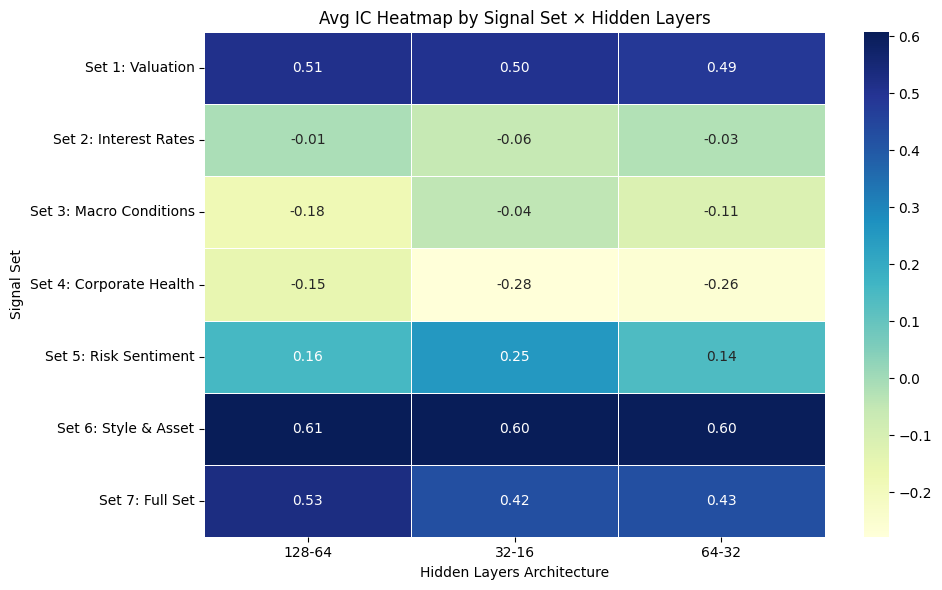

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 创建透视表：Signal Set × Hidden Layers
pivot_ic = results_df.pivot_table(
    index="Signal Set",
    columns="Hidden Layers",
    values="Avg IC"
)

# 画热力图
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_ic,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white'
)
plt.title("Avg IC Heatmap by Signal Set × Hidden Layers")
plt.xlabel("Hidden Layers Architecture")
plt.ylabel("Signal Set")
plt.tight_layout()
plt.show()